# Leanding Club Case Study

Imports and basic set-up

In [1]:
import warnings
from os import getcwd
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
sns.set_style('darkgrid')
# plt.style.use('seaborn-v0_8-pastel')

In [3]:
PRJ_DIR = getcwd()
DATA_DIR = join(PRJ_DIR, 'data')

## Step 0: Reading data

In [4]:
df = pd.read_csv(join(DATA_DIR, 'loan.csv'))
df.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077175,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [5]:
data_dict = pd.read_excel(join(DATA_DIR, 'Data_Dictionary.xlsx'))
data_dict = data_dict.dropna()
data_dict.sample(5)

,LoanStatNew,Description
93,tax_liens,Number of tax liens
56,mths_since_recent_inq,Months since most recent inquiry.
65,num_op_rev_tl,Number of open revolving accounts
61,num_actv_rev_tl,Number of currently active revolving trades
99,total_acc,The total number of credit lines currently in the borrower's credit file


## Step 1: Cleaning

### Choosing columns
There are columns with `Nan` values.

In [6]:
df.isna().sum()

id                                    0
member_id                             0
loan_amnt                             0
funded_amnt                           0
funded_amnt_inv                       0
term                                  0
int_rate                              0
installment                           0
grade                                 0
sub_grade                             0
emp_title                          2459
emp_length                         1075
home_ownership                        0
annual_inc                            0
verification_status                   0
issue_d                               0
loan_status                           0
pymnt_plan                            0
url                                   0
desc                              12942
purpose                               0
title                                11
zip_code                              0
addr_state                            0
dti                                   0


As seen above, there are columns which do not contain any values. Some of the columns contain not but few values.

In [7]:
(df.isna().sum() >= 0.5 * df.shape[0]).sum()

57

57 columns have more than 50% vlues as null. I am choosing not to use them and dropping them from analysis.

In [8]:
column_names = df.columns[df.isna().sum() <= 0.50 * df.shape[0]].tolist()
data_df = df[column_names]
del df
data_df.sample(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
34269,454130,562069,6000,6000,5875.0,36 months,8.94%,190.63,A,A5,RCM Inc.,3 years,RENT,30000.0,Not Verified,Nov-09,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=454130,"562069 added on 10/23/09 > Need a loan to pay for an engagement ring. I have very little debt, great credit history and not much other monthly expenses.",other,Engagment Ring Loan,146xx,NY,14.72,0,Jan-04,0,4,0,144,5.80%,6,f,0.0,0.0,6862.625071,6719.65,6000.0,862.63,0.0,0.0,0.0,Nov-12,207.27,Nov-12,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
19473,675276,863017,10000,10000,9950.0,36 months,9.63%,320.94,B,B1,faa,10+ years,OWN,158000.0,Verified,Feb-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=675276,NaN,major_purchase,purchase loan,553xx,MN,22.24,0,Jun-87,1,9,0,56373,71%,22,f,0.0,0.0,10159.122900,10108.32,10000.0,159.12,0.0,0.0,0.0,Jun-11,2.33,May-11,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
17777,707056,899360,4000,4000,4000.0,36 months,6.92%,123.37,A,A3,Fisher Scientific,2 years,RENT,50004.0,Source Verified,Mar-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=707056,NaN,debt_consolidation,Debt Consolidation Loan,070xx,NJ,5.28,0,Oct-03,1,5,0,4528,18.60%,13,f,0.0,0.0,4441.006169,4441.01,4000.0,441.01,0.0,0.0,0.0,Apr-14,127.62,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0


Another thing to check in the remaining column is the numbeor of unique values found in the each column

In [9]:
data_df.nunique()

id                            39717
member_id                     39717
loan_amnt                       885
funded_amnt                    1041
funded_amnt_inv                8205
term                              2
int_rate                        371
installment                   15383
grade                             7
sub_grade                        35
emp_title                     28820
emp_length                       11
home_ownership                    5
annual_inc                     5318
verification_status               3
issue_d                          55
loan_status                       3
pymnt_plan                        1
url                           39717
desc                          26526
purpose                          14
title                         19615
zip_code                        823
addr_state                       50
dti                            2868
delinq_2yrs                      11
earliest_cr_line                526
inq_last_6mths              

There are columns which contain only 1 value for all the rows. We are choosing not to use them either as they are not adding any information wrt to our target variable

In [10]:
(data_df.nunique() <= 1).sum()

9

9 columns will be additionally removed from our analysis.

In [11]:
column_names = data_df.columns[data_df.nunique() > 1]
data_df = data_df[column_names]
data_df.sample(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
232,1066530,1300506,10000,10000,10000.0,36 months,6.62%,307.04,A,A2,penske logistics,5 years,RENT,45000.0,Not Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=1066530,NaN,credit_card,Credit Card,441xx,OH,26.85,0,Jun-81,0,15,0,10133,70.40%,40,0.0,0.0,11053.31000,11053.31,10000.00,1053.31,0.0,0.00,0.0000,Jan-15,319.94,Dec-14,0.0
31393,495809,635159,5000,5000,5000.0,36 months,11.36%,164.56,B,B5,Brookside Laboratories,5 years,MORTGAGE,61498.0,Not Verified,Mar-10,Fully Paid,https://lendingclub.com/browse/loanDetail.action?loan_id=495809,NaN,debt_consolidation,credit card consolidation,458xx,OH,17.46,0,Dec-95,0,13,0,5756,31.10%,40,0.0,0.0,5869.60635,5869.61,5000.00,869.61,0.0,0.00,0.0000,Aug-12,1431.51,Aug-12,0.0
8425,865049,1078293,12000,12000,12000.0,36 months,11.49%,395.66,B,B4,UBS Securities LLC,5 years,MORTGAGE,108000.0,Not Verified,Sep-11,Charged Off,https://lendingclub.com/browse/loanDetail.action?loan_id=865049,Borrower added on 08/26/11 > Debt consolidation and int rate reduction.<br/> Borrower added on 08/29/11 > The beginning steps of debt consolidation. No more living with credit cards looming. Have a tin line to get rid of all debt in the next 3 years any help is greatly appreciated.<br/>,credit_card,Debt b gone,066xx,CT,15.81,0,Aug-97,1,11,1,23103,66%,16,0.0,0.0,11173.90000,11173.90,8585.02,2117.05,0.0,471.83,4.7183,Jan-14,44.40,May-14,1.0


In [12]:
column_desc_df = pd.DataFrame([(i, data_df[i].isna().sum(),
                                data_df[i].nunique(),
                                data_dict[data_dict.LoanStatNew == i]['Description'].values[0])
                               for i in data_df.columns],
                              columns=['Column_Name', 'Num_NAs',
                                       'Num_unique_vals', 'Description'])
column_desc_df

,Column_Name,Num_NAs,Num_unique_vals,Description
0,id,0,39717,A unique LC assigned ID for the loan listing.
1,member_id,0,39717,A unique LC assigned Id for the borrower member.
2,loan_amnt,0,885,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,funded_amnt,0,1041,The total amount committed to that loan at that point in time.
4,funded_amnt_inv,0,8205,The total amount committed by investors for that loan at that point in time.
5,term,0,2,The number of payments on the loan. Values are in months and can be either 36 or 60.
6,int_rate,0,371,Interest Rate on the loan
7,installment,0,15383,The monthly payment owed by the borrower if the loan originates.
8,grade,0,7,LC assigned loan grade
9,sub_grade,0,35,LC assigned loan subgrade


In [13]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       39717 non-null  int64  
 1   member_id                39717 non-null  int64  
 2   loan_amnt                39717 non-null  int64  
 3   funded_amnt              39717 non-null  int64  
 4   funded_amnt_inv          39717 non-null  float64
 5   term                     39717 non-null  object 
 6   int_rate                 39717 non-null  object 
 7   installment              39717 non-null  float64
 8   grade                    39717 non-null  object 
 9   sub_grade                39717 non-null  object 
 10  emp_title                37258 non-null  object 
 11  emp_length               38642 non-null  object 
 12  home_ownership           39717 non-null  object 
 13  annual_inc               39717 non-null  float64
 14  verification_status   

In [14]:
def get_earliest_yr(x):
    x = int(x.split("-")[1])
    if 0 <= x <= 11:
        return str(2000 + x)
    return str(1900 + x)

In [15]:
data_df['term'] = data_df.term.apply(lambda x: int(x.strip().split(' ')[0]))
data_df['int_rate'] = data_df.int_rate.apply(lambda x: float(x.strip().strip('%')))

data_df['issue_d_month'] = data_df.issue_d.apply(lambda x: x.split('-')[0])
data_df['issue_d_year'] = data_df.issue_d.apply(lambda x: "20" + x.split('-')[1])

data_df['earliest_cr_line_month'] = data_df.earliest_cr_line.apply(lambda x: x.split('-')[0])
data_df['earliest_cr_line_year'] = data_df.earliest_cr_line.apply(get_earliest_yr)

data_df['last_pymnt_d_month'] = data_df.last_pymnt_d.apply(lambda x: x.split('-')[0] if isinstance(x, str) else x)
data_df['last_pymnt_d_year'] = data_df.last_pymnt_d.apply(lambda x: "20" + x.split('-')[1] if isinstance(x, str) else x)

data_df['last_credit_pull_d_month'] = data_df.last_credit_pull_d.apply(lambda x: x.split('-')[0] if isinstance(x, str) else x)
data_df['last_credit_pull_d_year'] = data_df.last_credit_pull_d.apply(lambda x: "20" + x.split('-')[1] if isinstance(x, str) else x)

data_df['emp_title'] = data_df.emp_title.apply(lambda x: x.strip().upper() if not isinstance(x, float) else x)
data_df['emp_length'] = data_df.emp_length.apply(lambda x: x if '<' not in str(x) else '<1 year')
data_df['revol_util'] = data_df.revol_util.apply(lambda x: float(x.strip("%")) if isinstance(x, str) else float(x))
data_df['title'] = data_df.title.apply(lambda x: x.strip().lower() if not isinstance(x, float) else x)

In [16]:
data_df = data_df.drop(['issue_d', 'earliest_cr_line', 'url', 'last_pymnt_d', 'last_credit_pull_d'], axis=1)

## Step 2: Uni-variate Analysis

### Annual Income

In [ ]:
data_df.annual_inc.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.annual_inc)
plt.title('Annual Income')
plt.show()

Here we encounter some outliers. It is evident from the 5 point summary that 75% of the annual incomes are below USD 100K, but the highest income is USD 6M. Analyzing this columns while considering all the values would not yield correct results and therefore we choose drop rows where the annual income is greater than USD 150K.

In [ ]:
data_df = data_df[(data_df.annual_inc <= 150_000)]
data_df.annual_inc.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.annual_inc)
plt.title('Annual Income')
plt.xticks(ticks=[])
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.annual_inc, kde=True)
plt.title('Annual Income')
plt.xlabel("")
plt.ylabel("")
plt.show()

We observe that:
- The median annual income is USD 57K
- Income of most of the applicants lie below USD 80K

### Last Payment Amount

In [ ]:
data_df.last_pymnt_amnt.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.last_pymnt_amnt)
plt.title('Last Payment')
plt.xticks(ticks=[])
plt.show()

Here we encounter some outliers. It is evident from the 5 point summary that 75% of the loan payment amounts are around USD 3200, but the highest income is around USD 36K. Analyzing this columns while considering all the values would not yield correct results and therefore we choose drop rows where the annual income is greater than USD 150K.

In [ ]:
data_df = data_df[(data_df.last_pymnt_amnt <= 8000)]
data_df.last_pymnt_amnt.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.last_pymnt_amnt)
plt.title('Last Payment done in $')
plt.xticks(ticks=[])
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.last_pymnt_amnt, kde=True)
plt.title('Last Payment done in $')
plt.show()

We observe that:
- More than 50% of the amount paid as the latest payment is less than $500

### Loan amount

In [ ]:
data_df.loan_amnt.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.loan_amnt)
plt.title('Loan Amount')
plt.show()

We observe that:
- The median amount that is applied for is USD 8200
- Only 25% of the applicants have applied for amounts greater than USD 13000

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.loan_amnt, bins=20, kde=True)
plt.title('Loan Amount')
plt.show()

### Funded Amount

In [ ]:
data_df.funded_amnt.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.funded_amnt)
plt.title('Funded Amount')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.funded_amnt, kde=True)
plt.title('Funded Amount')
plt.show()

We observe that:
- The median amount that is funded by the club is approximately USD 8000

### Amount Funded by Investor

In [ ]:
data_df.funded_amnt_inv.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.funded_amnt_inv)
plt.title('Amount Funded by Invertors')
plt.xticks(ticks=[])
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.funded_amnt_inv, bins=20, kde=True)
plt.title('Amount Funded by Invertors')
plt.show()

We observe that:
- The median amount that is funded by the investors is a approximately USD 8000
- Only 25% of the loans have been funded for more than USD 12000

### Term of the loan

In [ ]:
plt.figure(figsize=(4, 5))
data_df.term.value_counts().plot.bar()
plt.title("Term of the loan")
plt.xticks(ticks=[0 ,1], labels=['36 months', '60 months'], rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We have loans of 2 type of terms:
- 36 months or 3 years
- 60 months or 5 years

We observe that amount of loans issued for the 36 month period are far more than those issued for 60 month period.

### Interest Rates

In [ ]:
data_df.int_rate.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.int_rate)
plt.title('Interest Rate')
plt.xticks(ticks=[])
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.int_rate, bins=50, kde=True)
plt.title('Interest Rate')
plt.ylabel(None)
plt.show()

We observe that:
- **More than 75%** of the loans have an interest rate less than **15%**
- **50%** of the loans have an interest rate between ~**9%** and ~**14.25%** 

### Installments

In [ ]:
data_df.installment.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.installment)
plt.title('Installments')
plt.xticks(ticks=[])
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.installment, kde=True, bins=50)
plt.title('Installments')
plt.ylabel(None)
plt.show()

We observe that:
- Median installment paid is **~USD 250**
- **More than 75%** of the monthly installments are **below USD 390**

### Grade and Sub-Grade

In [ ]:
plt.figure(figsize=(5, 4))
data_df.grade.value_counts().plot.bar()
plt.title("Grade of loans")
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.sub_grade.value_counts().plot.bar()
plt.title("Sub-Grade of loans")
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- Most of the loans are **Grade B**, followed by **A**, and **C**
- Most of the loans are of sub-grade **A4** followed by **B3**, and **A5**

### Employee Title

> **NOTE**: The values of this columns are text. We observe that values indicating same employer name are repeated in different cases, and spellings. We tackled the case earlier by converting every value to upper case. 

In [ ]:
data_df.emp_title.value_counts()[:10]

We observed that:
- Most of the loans are issued to employees of **US Army**

### Employee Length

In [ ]:
data_df.emp_length.value_counts()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.emp_length.value_counts().plot.bar()
plt.title("Years of Continuous Employement")
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- More than **~7200** applicants have **more than 10 years** of continuous employment

### Home Ownership

In [ ]:
data_df.home_ownership.value_counts()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.home_ownership.value_counts().plot.bar()
plt.title("Type of home ownership")
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- More than **~17000** applicants are renters, closely followed by applicates with mortgage

### Verification Status of Income

In [ ]:
data_df.verification_status.value_counts()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.verification_status.value_counts().plot.bar()
plt.title("Status of Income/Income source Verification")
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- ~**44%** applicants' income is not verified
- Only ~**25%** of the applicants' source of income is verified

### Loan Status

In [ ]:
data_df.loan_status.value_counts()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.loan_status.value_counts().plot.bar()
plt.title("Status of loan")
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- More than **27K** loans have been fully paid
- **~5.5K** loans are actually bad loans i.e. the applicants defaulted

### Purpose of Loan

In [ ]:
data_df.purpose.str.upper().value_counts() / (~data_df.purpose.isna()).sum()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.purpose.str.upper().value_counts().plot.barh()
plt.title("Category of loan purpose")
plt.ylabel("")
plt.xlabel("Number of loans")
plt.show()

We observe that:
- Most popular reason for applying for a loan is **debt consilidation (~45%)**
- Least number of loan application are for **Renewable Energy**, **Education**, and **Housing** 

### Title

In [ ]:
data_df.title.value_counts()[:10]

We observe that:
- Most loans are applied for **Debt Consolidation**

### State of residence 

In [ ]:
data_df.addr_state.value_counts()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.addr_state.value_counts()[:5].plot.bar()
plt.title("Top-5 States with most applicants")
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.addr_state.value_counts()[-5:].plot.bar()
plt.title("Top-5 States with least applicants")
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- Most applicants are from the California, New York and Florida
- Idaho, Nebraska, and Maine are the states with least number of loan applications

### Debt-To-Income Ratio

In [ ]:
data_df.dti.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.dti)
plt.title('Debt to Income Ratio')
plt.xticks(ticks=[])
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.dti, kde=True)
plt.title('Debt to Income Ratio')
plt.show()

We observe that:
- The median ratio is 13.5, which is a quite good
- 25% of the applicants have DTI > 18.7

### Deliquincy in the past 2 years

In [ ]:
data_df.delinq_2yrs.value_counts()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.delinq_2yrs.value_counts()[1:].plot.bar()
plt.title("Number of delinqueny cases")
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- Most of the applicants have not shown any delinquent behviour in the past 2 years
- Less than 100 applicant have a record of 4 or more delinquency incidence in past 2 year

### Inquiries made in the past 6 months

In [ ]:
data_df.inq_last_6mths.value_counts()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.inq_last_6mths.value_counts().plot.bar()
plt.title("Number of delinqueny cases")
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

### Earliest Credit Line Year

The year the borrower's earliest reported credit line was opened

In [ ]:
data_df.earliest_cr_line_year.value_counts()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.earliest_cr_line_year.value_counts()[:10].plot.bar()
plt.title('Year of first applications by the applicants')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- Although the earliest line of credit for the applicants can be traced back to 1946, most of the applicant have thier first line of credit in the 1990s and 2000s

### Earliest Credit Line Month 

The month the borrower's earliest reported credit line was opened


In [ ]:
data_df.earliest_cr_line_month.value_counts()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.earliest_cr_line_month.value_counts().plot.bar()
plt.title('First Credit Month-wise split')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- Most applicants took their first loans in the month of October, followed by December and November

### Issued Year and month 

The month and the year in which loan was funded

In [ ]:
data_df.issue_d_year.value_counts()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.issue_d_year.value_counts().sort_index().plot.bar()
plt.title('Year-wise Loan issued')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- Most loans are issue in 2011
- There is a steady increase in the number of loans issues YoY

In [ ]:
data_df.issue_d_month.value_counts()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.issue_d_month.value_counts().plot.bar()
plt.title('Month-wise Loan issued over the years')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- Top-2 months are December and November with more than 4000 application every month
- January and February have the lowest number of applications

### Public Record Bankruptcies

Number of public record bankruptcies

In [1]:
data_df.pub_rec_bankruptcies.value_counts()

NameError: name 'data_df' is not defined

We observe that:
- There are 1513 borrowers who have declared bankruptcy among which only 6 have declared bankrupcies twice

### Last Credit Pulled date

The most recent month LC pulled the credit for this loan

In [ ]:
data_df.last_credit_pull_d_year.value_counts()

In [ ]:
data_df.last_credit_pull_d_month.value_counts()

### Last Payment Year and Month

In [ ]:
data_df.last_pymnt_d_year.value_counts()

In [ ]:
data_df.last_pymnt_d_month.value_counts()

### Collection Recovery Fee

In [ ]:
data_df.collection_recovery_fee.describe()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.collection_recovery_fee)
plt.title('Collection Recovery Fee')
plt.show()

> **NOTE**: Since the collection recovery fee is only applicable in case of bad loan, we are choosing not to remove outliers from this column.  

We observe that:
- Collection recovery fee is 0 for most of the application
- For the rest of them it is less than USD 5000

### Recoveries

In [ ]:
data_df.recoveries.describe()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.recoveries)
plt.title('Collection Recovery Fee')
plt.show()

> **NOTE**: Since the recoveries is only applicable in case of bad loan, we are choosing not to remove outliers from this column.  

We observe that:
- Recoveries is 0 for most of the application

### Total Recovered Late Fee

In [ ]:
data_df.total_rec_late_fee.describe()

Here also we can that the column doesn't have any significant data

### Total Recovery Interest

In [ ]:
data_df.total_rec_int.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.total_rec_int)
plt.title('Total Interest received till date')
plt.xticks(ticks=[])
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.total_rec_int, kde=True)
plt.title('Total Interest received till date')
plt.show()

### Total Recovery Principle 

In [ ]:
data_df.total_rec_prncp.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.total_rec_prncp)
plt.title('Total Principle received till date')
plt.xticks(ticks=[])
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.total_rec_prncp, kde=True)
plt.title('Total Principle received till date')
plt.show()

### Total Payment Funded by Investors

Total payment received for the amount invested by the investors

In [ ]:
data_df.total_pymnt_inv.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.total_pymnt_inv)
plt.title('Total Payment received till date for the investor')
plt.xticks(ticks=[])
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.total_pymnt_inv, kde=True)
plt.title('Total Payment received till date for the investor')
plt.show()

### Total Payment 

In [ ]:
data_df.total_pymnt.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.total_pymnt)
plt.title('Total Payemnt received till date')
plt.xticks(ticks=[])
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data_df.total_pymnt, kde=True)
plt.title('Total Payment received till date')
plt.show()

From this we can understand that the median amount of the total payment received is 9899 USD

### Out Principal Invested by Investors

Remaining outstanding principal for total amount funded by investors

In [ ]:
data_df.out_prncp_inv.describe()

From the above data we can understand that most of the investors money has been paid

### Out Principal

Remaining outstanding principal for total amount funded


In [ ]:
data_df.out_prncp.describe()

From these two insights we can understand that most of the people have 0 outstanding principle to be paid

### Total Accounts

The total number of credit lines currently in the borrower's credit file


In [ ]:
data_df.total_acc.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.total_acc)
plt.title('Total Number for each Applicant')
plt.xticks(ticks=[])
plt.show()

### Revolving Credit Utilization 

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [ ]:
data_df.revol_util.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.revol_util)
plt.title('Revolving Credit utilization')
plt.xticks(ticks=[])
plt.show()

### Revolving balance

In [ ]:
data_df.revol_bal.describe()

In [ ]:
plt.figure(figsize=(3, 8))
sns.boxplot(data_df.revol_bal)
plt.title('Revolving Balance')
plt.xticks(ticks=[])
plt.show()

We observe that:
- The median of the total revolving balance is **~USD 8200**

### Public Records

The number of derogatory public records

In [ ]:
data_df.pub_rec.value_counts()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.pub_rec.value_counts().plot.bar()
plt.title('Derogatory Public Records')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

These number show that the maximum of the borrowers don't have derogaotry public records

### Open Credit lines

The number of open credit lines in the borrower's credit file.

In [ ]:
data_df.open_acc.value_counts()

In [ ]:
plt.figure(figsize=(10, 5))
data_df.open_acc.value_counts()[:10].plot.bar()
plt.title('Open Credit Lines')
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("Number of loans")
plt.show()

We observe that:
- **~7000** applicants have 6 or 7 lines of credit
- **~600** applicants have more than 20 credit lines

## Step 3: Segmented Uni-Variate Analysis

### Segmenting based on Loan Status

#### Loan Amount, Funded Amount, Investor Amounts

**Mean**

In [17]:
temp_df = data_df.groupby(['loan_status']).agg({'loan_amnt': 'mean', 'funded_amnt':'mean', 'funded_amnt_inv':'mean'}).reset_index()
temp_df.columns = ['loan_status', 'loan_amount', 'funded_amount', 'funded_amount_inv']
temp_df

,loan_status,loan_amount,funded_amount,funded_amount_inv
0,Charged Off,12104.385108,11753.398792,10864.521324
1,Current,17053.991228,16485.701754,16318.265247
2,Fully Paid,10866.455994,10618.520486,10112.837414


In [18]:
temp_df = temp_df.melt(id_vars='loan_status', var_name='agg_fn', value_name='agg_value')
temp_df

,loan_status,agg_fn,agg_value
0,Charged Off,loan_amount,12104.385108
1,Current,loan_amount,17053.991228
2,Fully Paid,loan_amount,10866.455994
3,Charged Off,funded_amount,11753.398792
4,Current,funded_amount,16485.701754
5,Fully Paid,funded_amount,10618.520486
6,Charged Off,funded_amount_inv,10864.521324
7,Current,funded_amount_inv,16318.265247
8,Fully Paid,funded_amount_inv,10112.837414


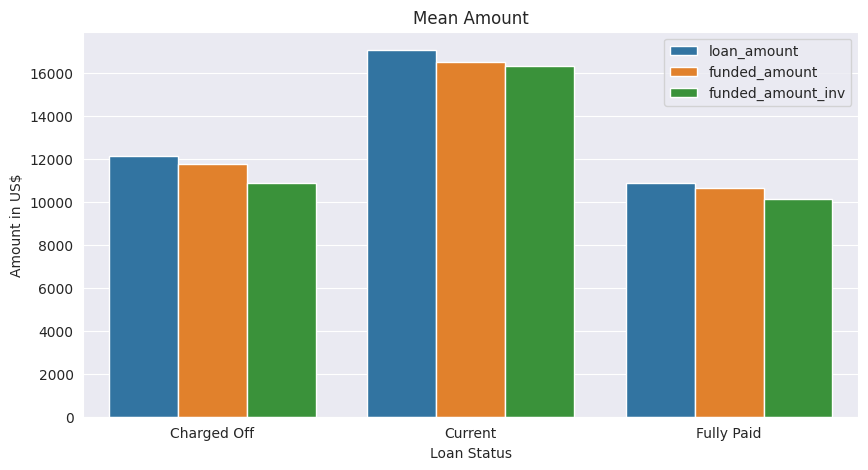

In [19]:
plt.figure(figsize=(10, 5))
sns.barplot(data=temp_df, x='loan_status', y='agg_value', hue='agg_fn')
plt.title("Mean Amount")
plt.xlabel("Loan Status")
plt.ylabel("Amount in US$")
plt.legend()
plt.show()

**Median**

In [20]:
temp_df = data_df.groupby(['loan_status']).agg({'loan_amnt': 'median',
                                                'funded_amnt':'median',
                                                'funded_amnt_inv':'median'}).reset_index()
temp_df.columns = ['loan_status', 'loan_amount', 'funded_amount', 'funded_amount_inv']
temp_df

,loan_status,loan_amount,funded_amount,funded_amount_inv
0,Charged Off,10000.0,10000.0,9401.209477
1,Current,15825.0,15225.0,15000.000000
2,Fully Paid,9600.0,9200.0,8500.000000


In [21]:
temp_df = temp_df.melt(id_vars='loan_status', var_name='agg_fn', value_name='agg_value')
temp_df

,loan_status,agg_fn,agg_value
0,Charged Off,loan_amount,10000.000000
1,Current,loan_amount,15825.000000
2,Fully Paid,loan_amount,9600.000000
3,Charged Off,funded_amount,10000.000000
4,Current,funded_amount,15225.000000
5,Fully Paid,funded_amount,9200.000000
6,Charged Off,funded_amount_inv,9401.209477
7,Current,funded_amount_inv,15000.000000
8,Fully Paid,funded_amount_inv,8500.000000


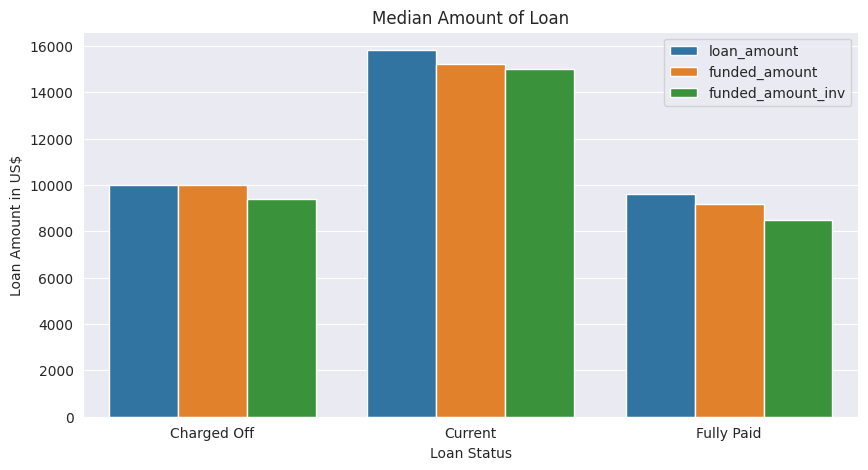

In [22]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=temp_df, x='loan_status', y='agg_value', hue='agg_fn')
plt.title("Median Amount of Loan")
plt.xlabel("Loan Status")
plt.ylabel("Loan Amount in US$")
plt.legend()
plt.show()
del temp_df

#### Interest Rate

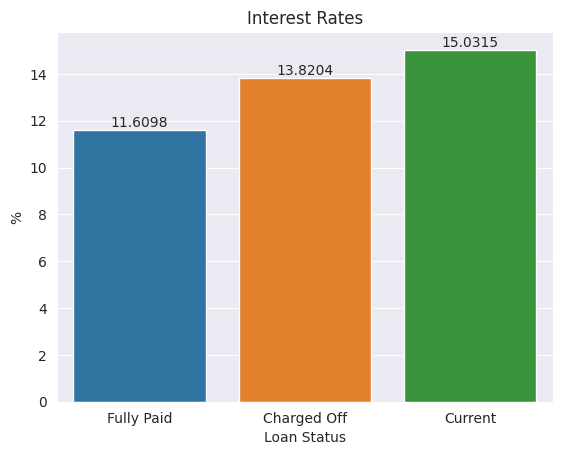

In [23]:
plt.figure()
ax = sns.barplot(data=data_df, x='loan_status', y='int_rate', estimator='mean', errorbar=None)
ax.bar_label(ax.containers[0])
plt.title("Interest Rates")
plt.xlabel("Loan Status")
plt.ylabel("%")
plt.show()

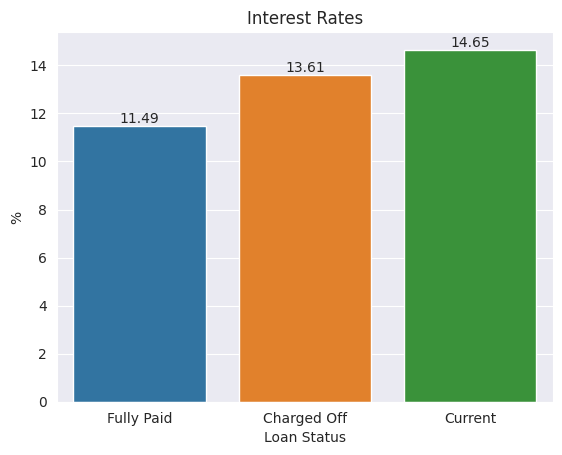

In [24]:
plt.figure()
ax = sns.barplot(data=data_df, x='loan_status', y='int_rate', estimator='median', errorbar=None)
ax.bar_label(ax.containers[0])
plt.title("Interest Rates")
plt.xlabel("Loan Status")
plt.ylabel("%")
plt.show()